Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/CNN-Case-Study/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/CNN-Case-Study/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180
img_size = (img_height, img_width)

Use 80% of the images for training, and 20% for validation.

In [8]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,  # Use 20% of data for validation
    subset = "training",  # Specify subset as "training"
    seed = 123,  # Ensure reproducibility
    image_size = img_size,
    batch_size = batch_size  # Batch size
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,  # Use 20% of data for validation
    subset = "validation",  # Specify subset as "training"
    seed = 123,  # Ensure reproducibility
    image_size = img_size,
    batch_size = batch_size  # Batch size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

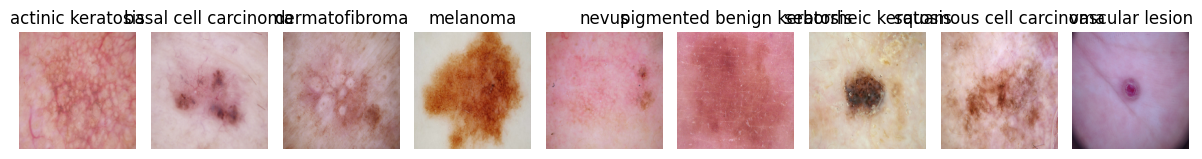

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# Initialize a dictionary to store one image per class
class_images = {class_name: None for class_name in class_names}
count_of_images = 0
total_classes = len(class_names)

# Iterate through the dataset
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        # If the class hasn't been visualized yet, store this image
        if class_images[class_name] is None:
            class_images[class_name] = img.numpy()
            count_of_images += 1
    # Break when we have one image for each class
    if count_of_images == total_classes:
        break


# Plot one image for each class
plt.figure(figsize=(12, 8))
for index, class_name in enumerate(class_names):
    ax = plt.subplot(1, len(class_names), index + 1)
    plt.imshow(class_images[class_name].astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# Normalize pixel values using Rescaling - experimental is deprecated in latest tensorflow
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = val_ds.map(lambda x, y: (normalization_layer(x), y))


# Define the CNN model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization to prevent overfitting
    layers.Dense(9, activation='softmax')  # 9 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 709s 3s/step - accuracy: 0.2005 - loss: 2.1837 - val_accuracy: 0.2349 - val_loss: 1.9953
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.2718 - loss: 1.9506 - val_accuracy: 0.3043 - val_loss: 1.8369
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3726 - loss: 1.7744 - val_accuracy: 0.4609 - val_loss: 1.5434
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4377 - loss: 1.6074 - val_accuracy: 0.4586 - val_loss: 1.4916
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4863 - loss: 1.4962 - val_accuracy: 0.4541 - val_loss: 1.5416
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4758 - loss: 1.4945 - val_accuracy: 0.5302 - val_loss: 1.4423
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5212 - loss: 1.3998 - val_accuracy: 0.5369 - val_loss: 1.4052
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5308 - loss: 1.3592 - val_accuracy: 0.5101 - 

### Visualizing training results

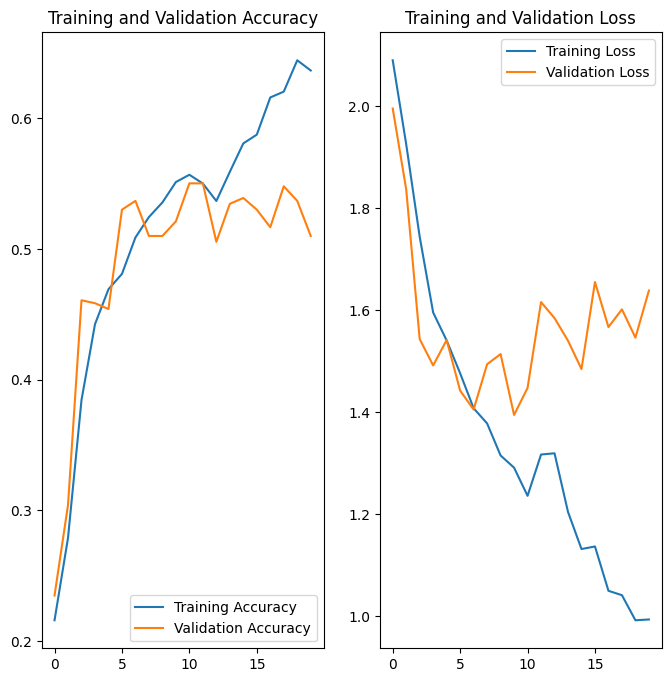

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Finding on the first base model**

The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

The accuracy is just around 75-80% because there are enough features to remember the pattern.

But again, it's too early to comment on the overfitting & underfitting debate

In [19]:
data_augument = keras.Sequential([
                             layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.RandomRotation(0.2, fill_mode='reflect'),
                             layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


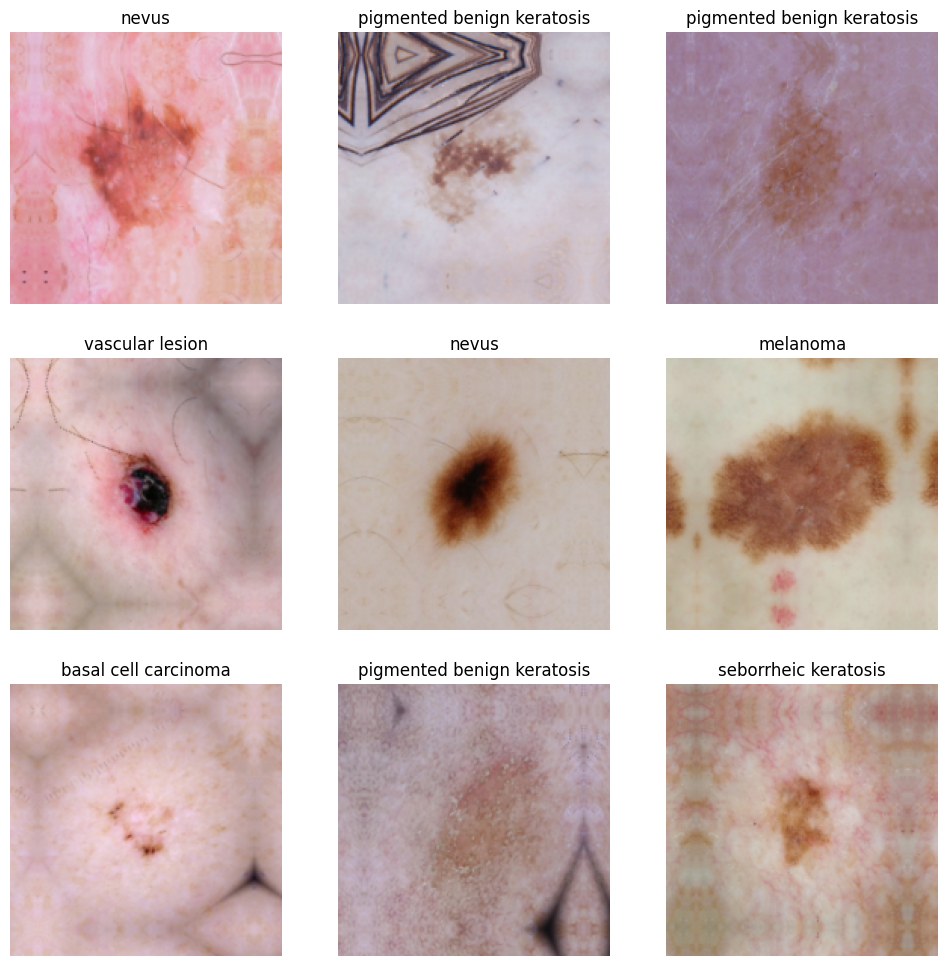

In [20]:
# visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model

In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [23]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [24]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.1776 - loss: 2.0953 - val_accuracy: 0.1499 - val_loss: 2.0408
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.1774 - loss: 2.0382 - val_accuracy: 0.1767 - val_loss: 2.0315
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.1962 - loss: 2.0248 - val_accuracy: 0.2058 - val_loss: 2.0233
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.2274 - loss: 2.0165 - val_accuracy: 0.1902 - val_loss: 2.0274
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.2174 - loss: 2.0197 - val_accuracy: 0.2192 - val_loss: 2.0167
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.1989 - loss: 2.0343 - val_accuracy: 0.2058 - val_loss: 2.0218
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.2136 - loss: 2.0077 - val_accuracy: 0.3043 - val_loss: 2.0274
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.1950 - loss: 2.0328 - val_accuracy: 0.2081 - 

### Visualizing the results

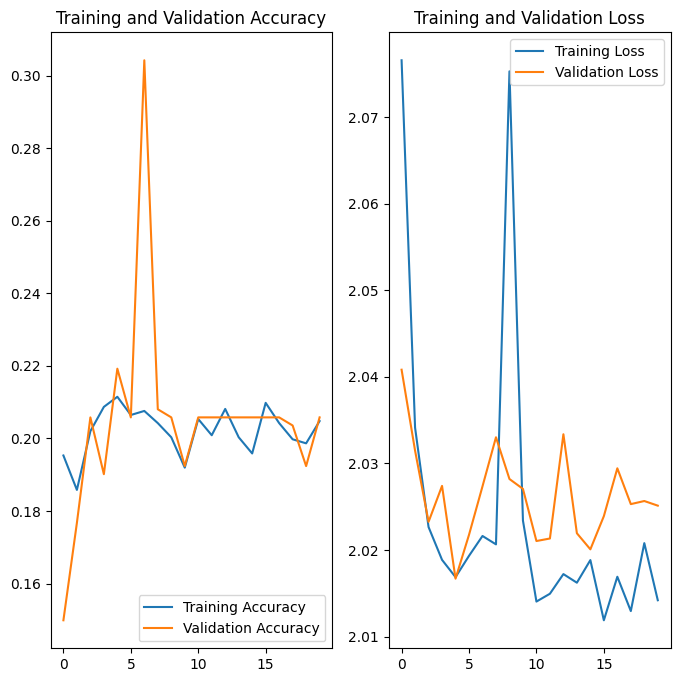

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Finding from Second Model**

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

We can increase the epochs to increase the accuracy so it's too early for judgement

 Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
1,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
2,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
3,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
4,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/CNN-Case-Study/Train/...,vascular lesion
2235,/content/gdrive/My Drive/CNN-Case-Study/Train/...,vascular lesion
2236,/content/gdrive/My Drive/CNN-Case-Study/Train/...,vascular lesion
2237,/content/gdrive/My Drive/CNN-Case-Study/Train/...,vascular lesion


In [27]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
1,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
2,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
3,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
4,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/CNN-Case-Study/Train/...,vascular lesion
2235,/content/gdrive/My Drive/CNN-Case-Study/Train/...,vascular lesion
2236,/content/gdrive/My Drive/CNN-Case-Study/Train/...,vascular lesion
2237,/content/gdrive/My Drive/CNN-Case-Study/Train/...,vascular lesion


<BarContainer object of 9 artists>

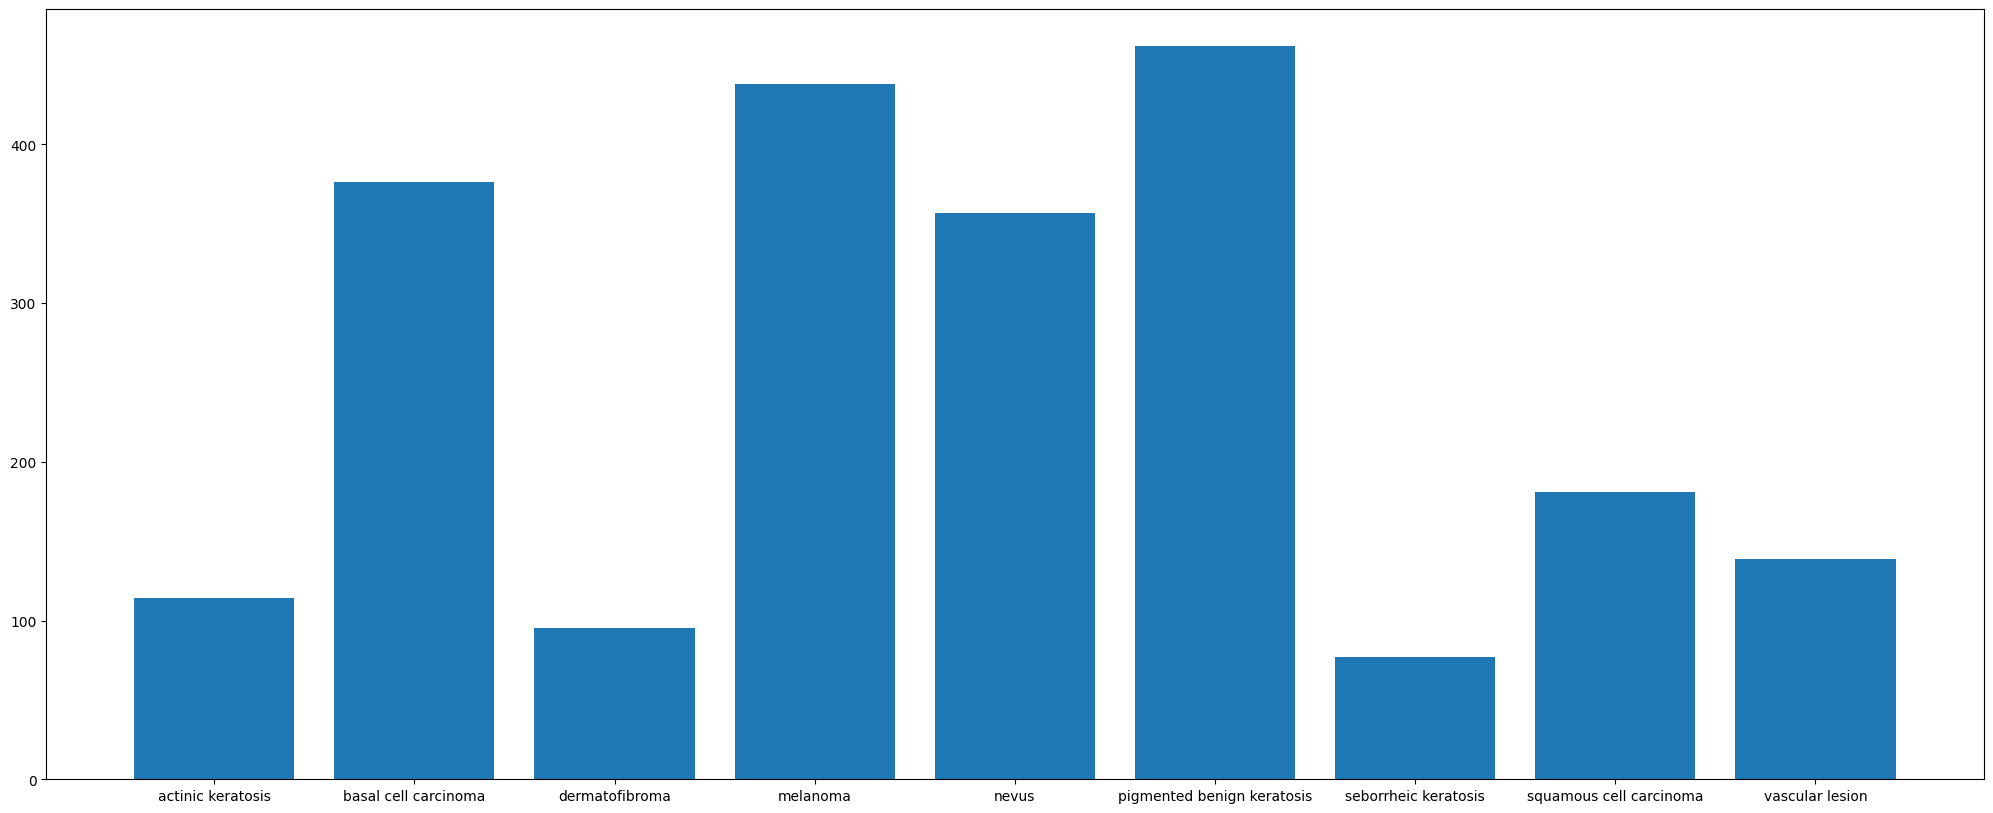

In [28]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?
Answer-1 :- squamous cell carcinoma has least number of samples

Answer-2:- actinic keratosis and dermatofibroma have proportionate number of classes.
melanoma and pigmented benign keratosis have proprtionate number of classes

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset="/content/gdrive/My Drive/CNN-Case-Study/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN-Case-Study/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7937B0FC76D0>: 100%|██████████| 500/500 [00:18<00:00, 27.23 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN-Case-Study/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7937B0E279A0>: 100%|██████████| 500/500 [00:19<00:00, 26.14 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN-Case-Study/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7937B0E37D60>: 100%|██████████| 500/500 [00:18<00:00, 26.90 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN-Case-Study/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x79382029BDC0>: 100%|██████████| 500/500 [01:33<00:00,  5.36 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN-Case-Study/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2314x2067 at 0x7937BA52AA10>: 100%|██████████| 500/500 [01:14<00:00,  6.72 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN-Case-Study/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7937BA42A890>: 100%|██████████| 500/500 [00:19<00:00, 26.07 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN-Case-Study/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7937BA184790>: 100%|██████████| 500/500 [00:41<00:00, 11.98 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN-Case-Study/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7937B0E5B970>: 100%|██████████| 500/500 [00:19<00:00, 26.11 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN-Case-Study/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7937BA5D3610>: 100%|██████████| 500/500 [00:21<00:00, 23.47 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/CNN-Case-Study/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011161.jpg_b7a54d03-1102-4850-98d4-875d527b3eb7.jpg',
 '/content/gdrive/My Drive/CNN-Case-Study/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010810.jpg_af15a63b-8a77-4d35-b636-a13cbdc5052e.jpg',
 '/content/gdrive/My Drive/CNN-Case-Study/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010890.jpg_02085573-9302-49c4-89a6-740dd23d05a6.jpg',
 '/content/gdrive/My Drive/CNN-Case-Study/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011166.jpg_108d3d90-6f2f-4f60-b2ba-0f905af6d7fa.jpg',
 '/content/gdrive/My Drive/CNN-Case-Study/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011057.jpg_3c8dc0d5-f6cc-4410-9fa6-7eaa0c85b11e.jpg',
 '/content/gdrive/My Drive/CNN-Case-Study/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011094.jpg_1f2741e3-0793-445d-afe6-00ca237df341.jpg',
 '/c

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [43]:
original_df.head(2)

,Path,Label
0,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis
1,/content/gdrive/My Drive/CNN-Case-Study/Train/...,actinic keratosis


In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [45]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [47]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [49]:
data_dir_train="/content/gdrive/My Drive/CNN-Case-Study/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [52]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Compile your model (Choose optimizer and loss function appropriately)

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [ ]:
epochs =30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 307ms/step - accuracy: 0.1423 - loss: 2.2176 - val_accuracy: 0.1774 - val_loss: 2.1522
Epoch 2/30
 27/169 ━━━━━━━━━━━━━━━━━━━━ 32s 231ms/step - accuracy: 0.1566 - loss: 2.1300

####  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Accuracy on training data has increased by using Augmentor library

Model is still overfitting

The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

The Model can be further improved by tuning the hyperparameter